In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
# compose tranformations for the images
# first transform the input data to a torch tensor
# then normalize the data
# the mean and stanndard deviation are defined individually for each color channel
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# download the CIFAR-10 training dataset and apply the above defined transformation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# load the training data (minibatches of 4)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# download the CIFAR-10 test dataset and apply the above defined transformation
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # undo the normalization
    img = img / 2 + 0.5
    
    # retrieve the numpy ndarray
    np_img = img.numpy()
    
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

horse   dog horse  bird


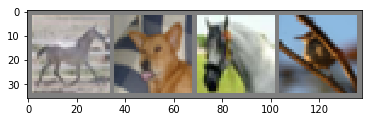

In [16]:
# get some random training images

# instantiate an iterator over the training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
# define a ConvNet
class Net(nn.Module):
    
    # define the class constructor
    def __init__(self):
        # execute the constructor of the superclass
        super(Net, self).__init__()
        
        # convolutional layer - 3 input channels, 6 filters of dimension 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # a max pooling layer of dimension 2 x 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # convolutional layer - 6 input channels, 16 filters of dimension 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # fully connected layer with weight matrix of dimension (16 * 5 * 5) x 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        # fully connected layer with weight matrix of dimension 120 x 84
        self.fc2 = nn.Linear(120, 84)
        
        # fully connected layer with weight matrix of dimension 84 x 10
        self.fc3 = nn.Linear(84, 10)
        
    # define the forward pass
    def forward(self, x):
        # convolution layer 1 -> ReLU -> max-pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # convolution layer 2 -> ReLU -> max-pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten x to row-vector
        x = x.view(-1, 16 * 5 * 5)
        
        # fully connected layer 1 -> ReLU
        x = F.relu(self.fc1(x))

        # fully connected layer 2 -> ReLU
        x = F.relu(self.fc2(x))
        
        # fully connected layer 3
        x = self.fc3(x)
        
        return x

In [19]:
# instantiate a ConvNet instance
net = Net()

In [20]:
import torch.optim as optim

# loss criterion
criterion = nn.CrossEntropyLoss()

# stochastic gradient descent with a learning rate of 0.001 and 0.9 momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
# go through two epochs
for epoch in np.arange(2):
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # set the gradient buffers to 0
        optimizer.zero_grad()
        
        # forward + backward + optimizer
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        # print after 2000 minibatches of 4
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0
            
print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.874
[1,  6000] loss: 1.671
[1,  8000] loss: 1.578
[1, 10000] loss: 1.519
[1, 12000] loss: 1.456
[2,  2000] loss: 1.390
[2,  4000] loss: 1.352
[2,  6000] loss: 1.322
[2,  8000] loss: 1.312
[2, 10000] loss: 1.289
[2, 12000] loss: 1.235
Finished Training


GroundTruth:    cat  ship  ship plane


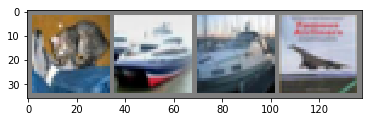

In [25]:
# display images from the test set
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
# implement forward pass for the images through the ConvNet
outputs = net(images)

# get the index of the class with the maximum score
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


In [27]:
# test on the entire dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [29]:
# class statistics

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 30 %
Accuracy of   car : 67 %
Accuracy of  bird : 36 %
Accuracy of   cat : 26 %
Accuracy of  deer : 38 %
Accuracy of   dog : 66 %
Accuracy of  frog : 45 %
Accuracy of horse : 75 %
Accuracy of  ship : 81 %
Accuracy of truck : 54 %
